In [280]:
# In this tutorial we will look at a dataset from from face recognition. 
# All photos used here are from the Swedish police collection of criminal identification photos (all more than 100 years old).
# They either used a mirror to get a profile face or made two photos combined into a single photo.
# The Face recognition software created face feature vectors (embeddings) that you will use in the visualisations.

# We need some basic modules for loading our dataset and to do the visualisations, but more will be imported later when they are being used.

import os                           # We want to be able to be able to concatenate file names
import numpy as np                  # We will use numpy

import matplotlib.pyplot as plt     # We will explore Visualisation with matplotlib

data_folderpath="datasets"           # Here you can change where your dataset is located on your computer


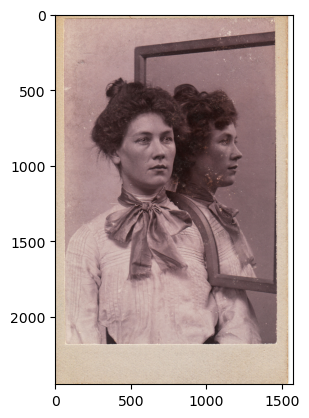

In [281]:
# But first we look at a typical sample image in the dataset.
# This was taken by the Police in Stockholm a long time ago...
# What will happen when we do face detection in this image?

import matplotlib.image as mpimg    # We want to be able to read images

filepath = os.path.join(data_folderpath, "0109A.jpg")
img = mpimg.imread(filepath)
plt.imshow(img)


In [282]:
# This fuction loads the three files containing data for Face Recognition.

# embeddings: are the face feature vectors
# faces:      contains 64x64 face images
# ids:        labels for each face and embedding. Note that we have 4 of each person. How come? You will find out later! :) 

def load_numpy_chunks(data_folderpath, normalize=False):
    def load_chunks(filename, normalize):
        filepath = os.path.join(data_folderpath, filename+".npy")
        f=open(filepath, 'rb')
        try:
            data=np.load(f, allow_pickle=True)
        except Exception:
            data=[]
        return np.array(data)

    embeddings = load_chunks("embeddings", normalize)
    faces = load_chunks("faces", normalize)
    ids = load_chunks("ids", normalize)
    ids = ids.flatten()

    # This will normalise the face feature vectors. Try it later!
    if normalize:
        if embeddings.ndim == 2:  # shape: (N, D)
            norms = np.linalg.norm(embeddings, axis=1, keepdims=True)
            embeddings = embeddings / (norms + 1e-8)  # avoid division by zero

    
    return embeddings, faces, ids

In [283]:
# Load the data

embeddings, faces, ids = load_numpy_chunks(data_folderpath)

In [284]:
# Which labels do we have in this subset?

print(ids)

[34 34 34 34 35 35 35 35 36 36 36 36 37 37 37 37 38 38 38 38 39 39 39 39
 40 40 40 40 41 41 41 41 42 42 42 42 43 43 43 43 44 44 44 44 45 45 45 45
 46 46 46 46 47 47 47 47 48 48 48 48 49 49 49 49 50 50 50 50 51 51 51 51
 52 52 52 52 53 53 53 53 54 54 54 54 55 55 55 55 56 56 56 56 57 57 57 57
 58 58 58 58 59 59 59 59 60 60 60 60 61 61 61 61 62 62 62 62 63 63 63 63
 64 64 64 64 65 65 65 65 66 66 66 66 67 67 67 67 68 68 68 68 69 69 69 69
 70 70 70 70 71 71 71 71 72 72 72 72 73 73 73 73]


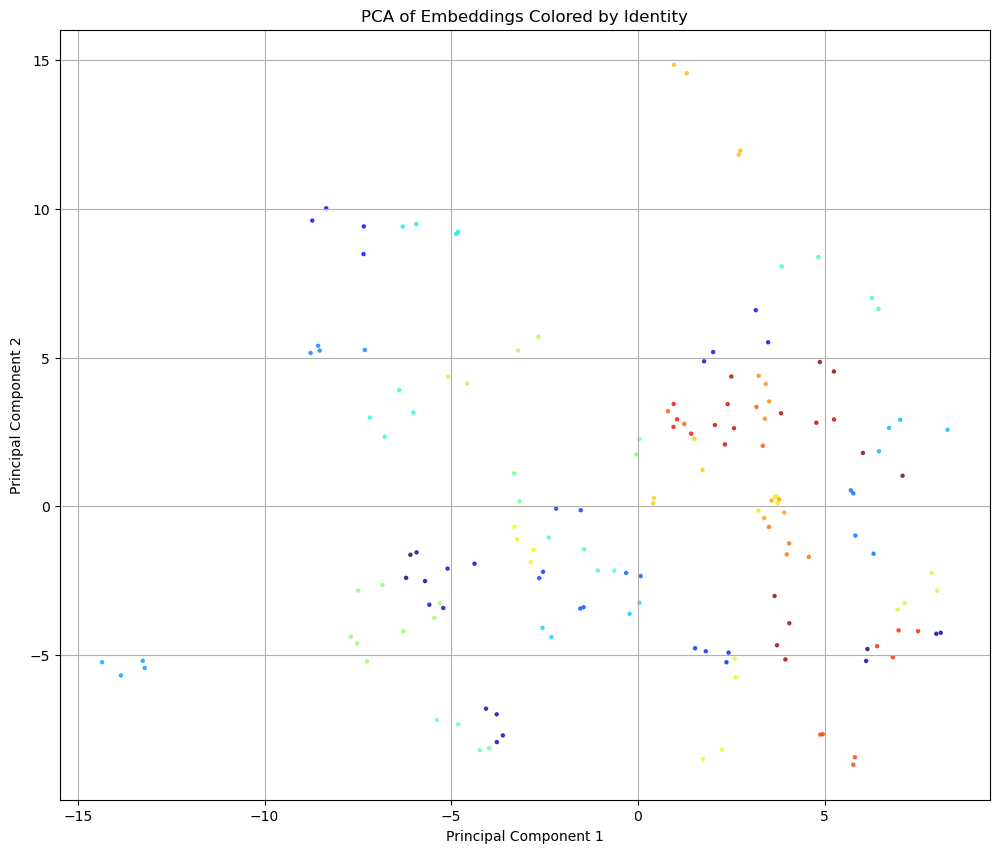

In [285]:
# PCA is used for both compression and visualisation
# Here the 512 long embeddings are compressed into 2 dimensions and can therefore be plotted in 2D
# Is PCA working well for this data? Why not?

from sklearn.decomposition import PCA # We need to import PCA

# Apply PCA
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings)

# Create the scatter plot
plt.figure(figsize=(12, 10))
scatter = plt.scatter(
    embeddings_pca[:, 0],
    embeddings_pca[:, 1],
    c=ids,
    cmap='jet',  # You can try other colormaps too, e.g. 'viridis', 'tab20', etc.
    s=5,
    alpha=0.7
)
plt.title("PCA of Embeddings Colored by Identity")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)

In [286]:
# Let's use a more powerful dimensionality reduction method
# Why randomness?

from sklearn.manifold import TSNE # Import t-SNE

def run_tsne(embeddings, labels=None, perplexity=30, n_components=2, random_state=42):
    print("Running t-SNE...")
    tsne = TSNE(n_components=n_components, perplexity=perplexity, init="pca", random_state=random_state)
    tsne_results = tsne.fit_transform(embeddings)
    
    # Plot
    plt.figure(figsize=(10, 8))
    if labels is not None:
        scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='tab10', s=10, alpha=0.7)
        #plt.legend(*scatter.legend_elements(), title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        plt.scatter(tsne_results[:, 0], tsne_results[:, 1], s=10, alpha=0.7)

    plt.title("t-SNE visualization of embeddings")
    plt.tight_layout()
    plt.show()

    return tsne_results

Running t-SNE...


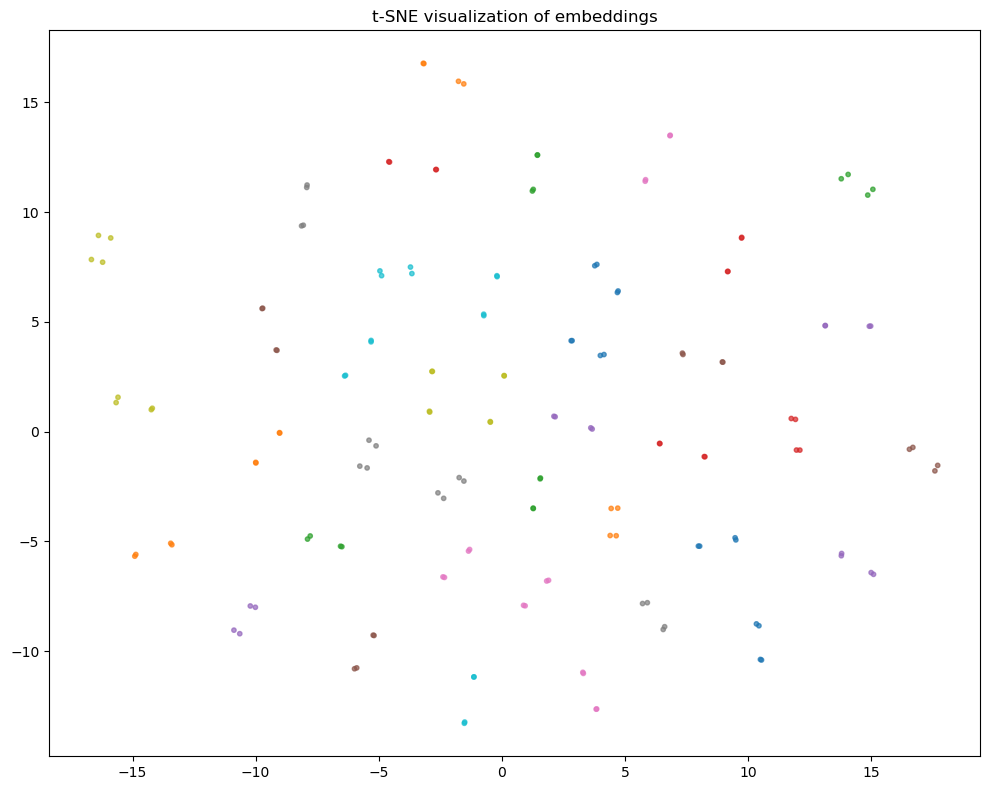

In [287]:
# Run t-SNE on the embeddings anc colour the plot using the labels
# Now we get a more consistent plot with the 4 embeddings of each identity close to each other
# Why can it still be hard to tell which ones belong to the same label? Look at the colours...
# What happens if you change: random_state=42 ?
# What happens if you lower the perplexity?

embeddings_2d = run_tsne(embeddings, ids)

In [288]:
# Now let's try to group all persons using convex hulls so that we do not mix up close points that happen to have the same colour

from scipy.spatial import ConvexHull # We need this module for convex hulls

def run_tsne_with_hulls(embeddings, labels=None, perplexity=30, n_components=2, random_state=42):
    print("Running t-SNE...")
    tsne = TSNE(n_components=n_components, perplexity=perplexity, init="pca", random_state=random_state)
    tsne_results = tsne.fit_transform(embeddings)

    # Plot
    plt.figure(figsize=(12, 10))
    unique_labels = np.unique(labels)
    cmap = plt.get_cmap('tab10', len(unique_labels))

    for i, label in enumerate(unique_labels):
        idx = labels == label
        points = tsne_results[idx]
        plt.scatter(points[:, 0], points[:, 1], label=f'ID {label}', alpha=0.6, s=10, color=cmap(i))

        # Draw convex hull if there are enough points
        if points.shape[0] >= 2:
            try:
                hull = ConvexHull(points)
                hull_points = np.append(hull.vertices, hull.vertices[0])  # close the loop
                plt.plot(points[hull_points, 0], points[hull_points, 1], color=cmap(i), linewidth=1)
            except:
                pass  # If convex hull fails, skip

    plt.title("t-SNE with Convex Hulls per ID")
    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()

    return tsne_results

Running t-SNE...


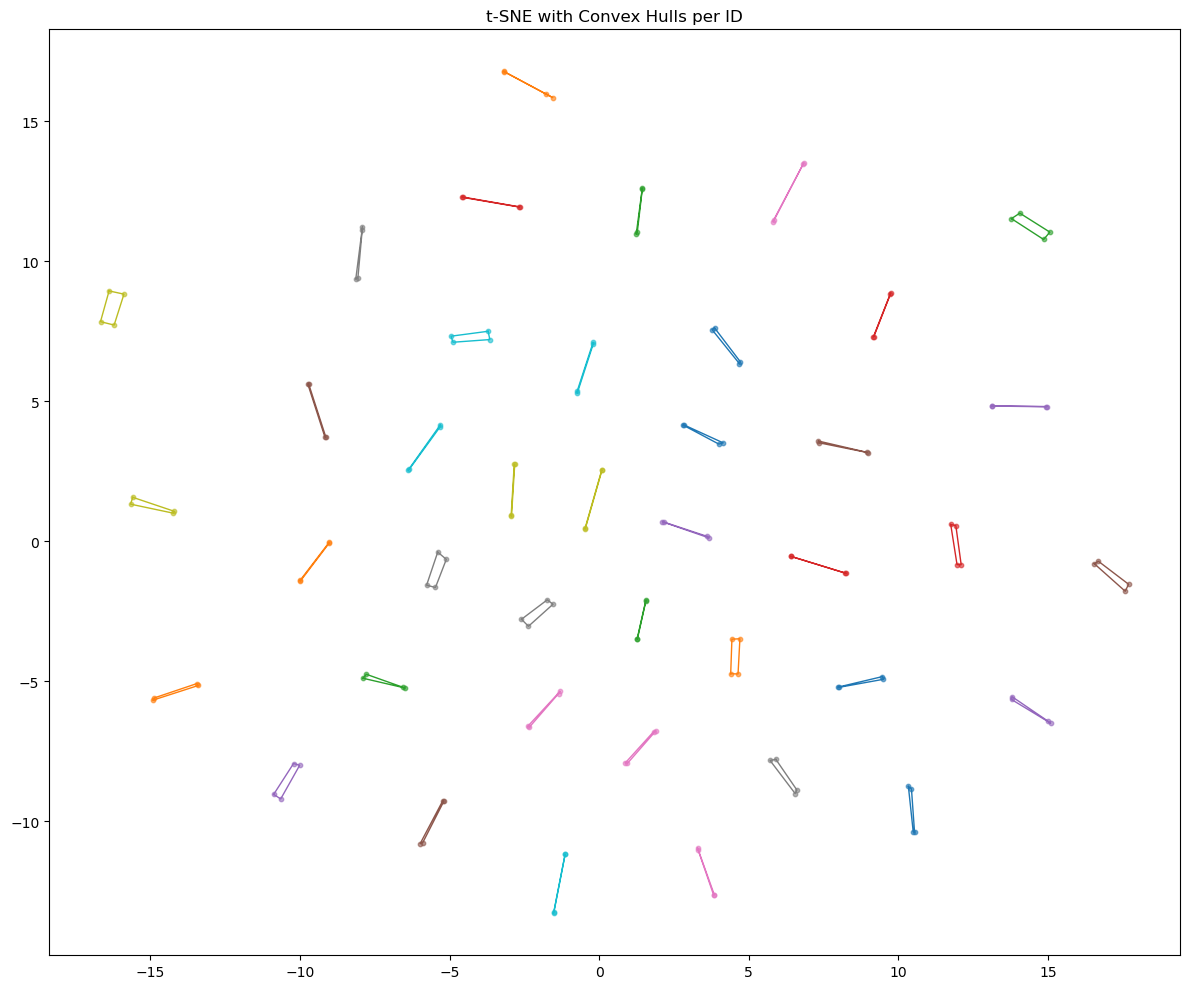

In [289]:
# Run this function for a better visualisation!
# Why are the points always grouped in pairs? Two are close and another two are furter away?
# We have the frontface and the profile face in the mirror, and they are relatively far away from each other.

embeddings_2d=run_tsne_with_hulls(embeddings, ids)

In [290]:
# Let´s look at the face photos!

from matplotlib.offsetbox import OffsetImage, AnnotationBbox # We need this module for scattering the faces

def imscatter(x, y, images, ax=None, zoom=0.4):
    if ax is None:
        ax = plt.gca()
    for x0, y0, img in zip(x, y, images):
        if isinstance(img, np.ndarray):
            # Optional: Convert grayscale to RGB
            if img.ndim == 2:
                img = np.stack([img]*3, axis=-1)
        imagebox = OffsetImage(img, zoom=zoom)
        ab = AnnotationBbox(imagebox, (x0, y0), frameon=False)
        ax.add_artist(ab)
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()



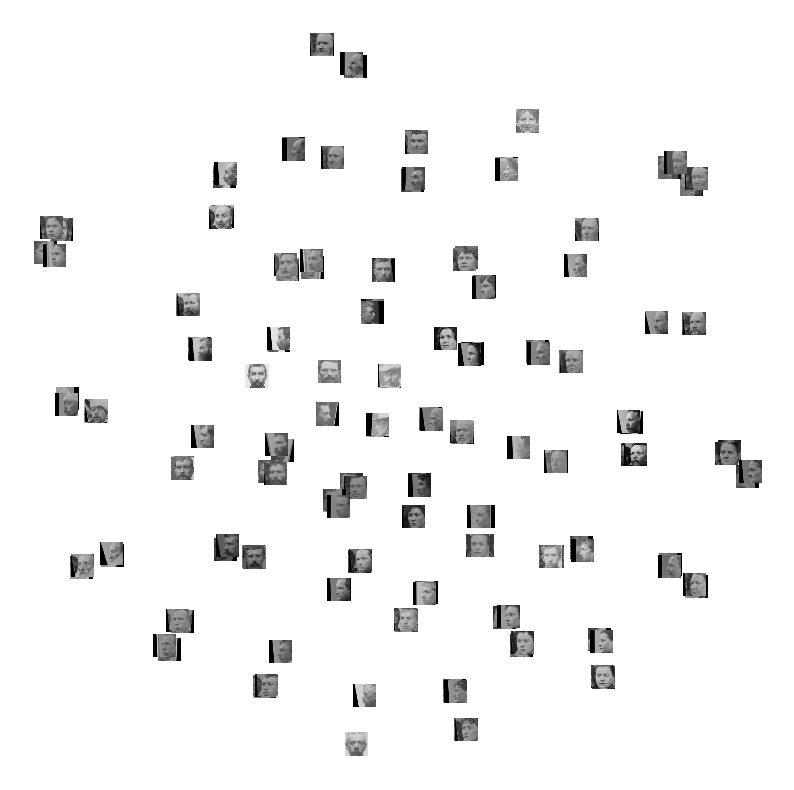

In [291]:
# Scatter the faces using the coordinates we got from t-SNE.
# What do you notice about faces?
# It is still kind of hard to see each face...

fig, ax = plt.subplots(figsize=(10, 10))
x = embeddings_2d[:, 0]
y = embeddings_2d[:, 1]
face_images = faces.reshape(-1, 64, 64) 
imscatter(x, y, face_images , ax=ax, zoom=0.25)
plt.axis('off')
plt.show()

In [292]:
# Let's make it possible to zoom in! 
# But first we need to be able to convert the data...

from PIL import Image
import base64
import io

def array_to_data_uri(img_array, size=(24, 24)):
    """Convert a 2D grayscale image array to a base64 data URI."""
    img = Image.fromarray(255-(img_array * 255).astype(np.uint8)).convert('L')
    img = img.resize(size)
    buffer = io.BytesIO()
    img.save(buffer, format='PNG')
    encoded_img = base64.b64encode(buffer.getvalue()).decode()
    return f'data:image/png;base64,{encoded_img}'

In [293]:
# Code for zoomable faces
# Try to zoom in to any group of 4 faces and see what you find!

import plotly.graph_objects as go # We need this module

fig = go.Figure()

for (x, y), face in zip(embeddings_2d[:], face_images.squeeze()[:]):
    fig.add_layout_image(
        dict(
            source=array_to_data_uri(face),
            xref="x", yref="y",
            x=x, y=y,
            sizex=.3, sizey=.3,
            xanchor="center", yanchor="middle",
            layer="above"
        )
    )

# Add invisible scatter to allow zoom/pan
fig.add_trace(go.Scatter(
    x=embeddings_2d[:, 0],
    y=embeddings_2d[:, 1],
    mode='markers',
    marker=dict(size=1, color='rgba(0,0,0,0)'),
    hoverinfo='skip'
))

fig.update_layout(
    title='t-SNE with Face Thumbnails',
    xaxis=dict(visible=False),
    yaxis=dict(visible=False),
    width=1200,
    height=1000,
    dragmode='zoom'
)

fig.show()

In [294]:
# So can you tell why we have four faces? And therfore also four data points...

# The code that performed face detection finds the front face and the profile face in the mirror.
# But then it also flips the faces horisontally and computes new embeddings for those. 
# This is not a normal procedure, but is used here to make a point:
# Are this embeddings equal to the non flipped ones? Why do you say so?


In [295]:
# This piece of code will compute the average of the four embeddings, which can be used as a (better?) feature vector for each person.

def group_and_average_embeddings(embeddings, ids, normalize=False):

    # Group by every 4 entries
    n_identities = len(ids) // 4
    D = embeddings.shape[1]

    averaged_embeddings = []
    new_ids = []

    for i in range(n_identities):
        start = i * 4
        end = start + 4

        group = embeddings[start:end]
        avg = np.mean(group, axis=0)
        if normalize:
            norm = np.linalg.norm(avg) 
            if norm > 0:  # The norm should never be zero, but this is good practice!
                avg = avg / norm

        averaged_embeddings.append(avg)
        new_ids.append(ids[start])  # All 4 should have same id
    
    averaged_embeddings = np.array(averaged_embeddings)  # (M, D)
    new_ids = np.array(new_ids)  # (M,)

    # Combine with original data
    combined_embeddings = np.vstack([embeddings, averaged_embeddings])
    combined_ids = np.concatenate([ids, new_ids])
    
    return combined_embeddings, combined_ids

Running t-SNE...


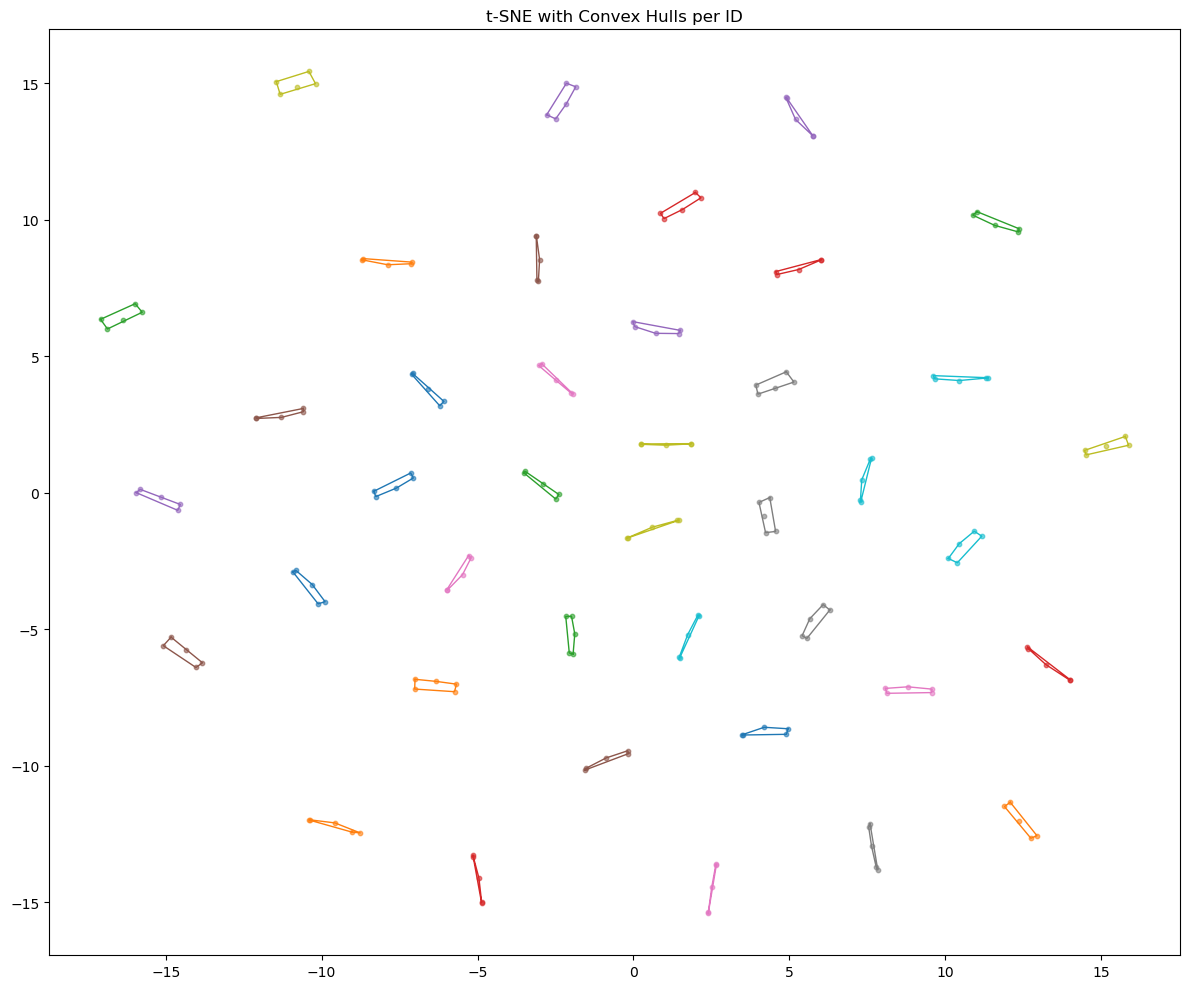

In [296]:
# First compute average of all groups of embeddings to create a new embedding
combined_embeddings, combined_ids = group_and_average_embeddings(embeddings, ids)
# Visualise it!
embeddings_2d=run_tsne_with_hulls(combined_embeddings, combined_ids)

Running t-SNE...


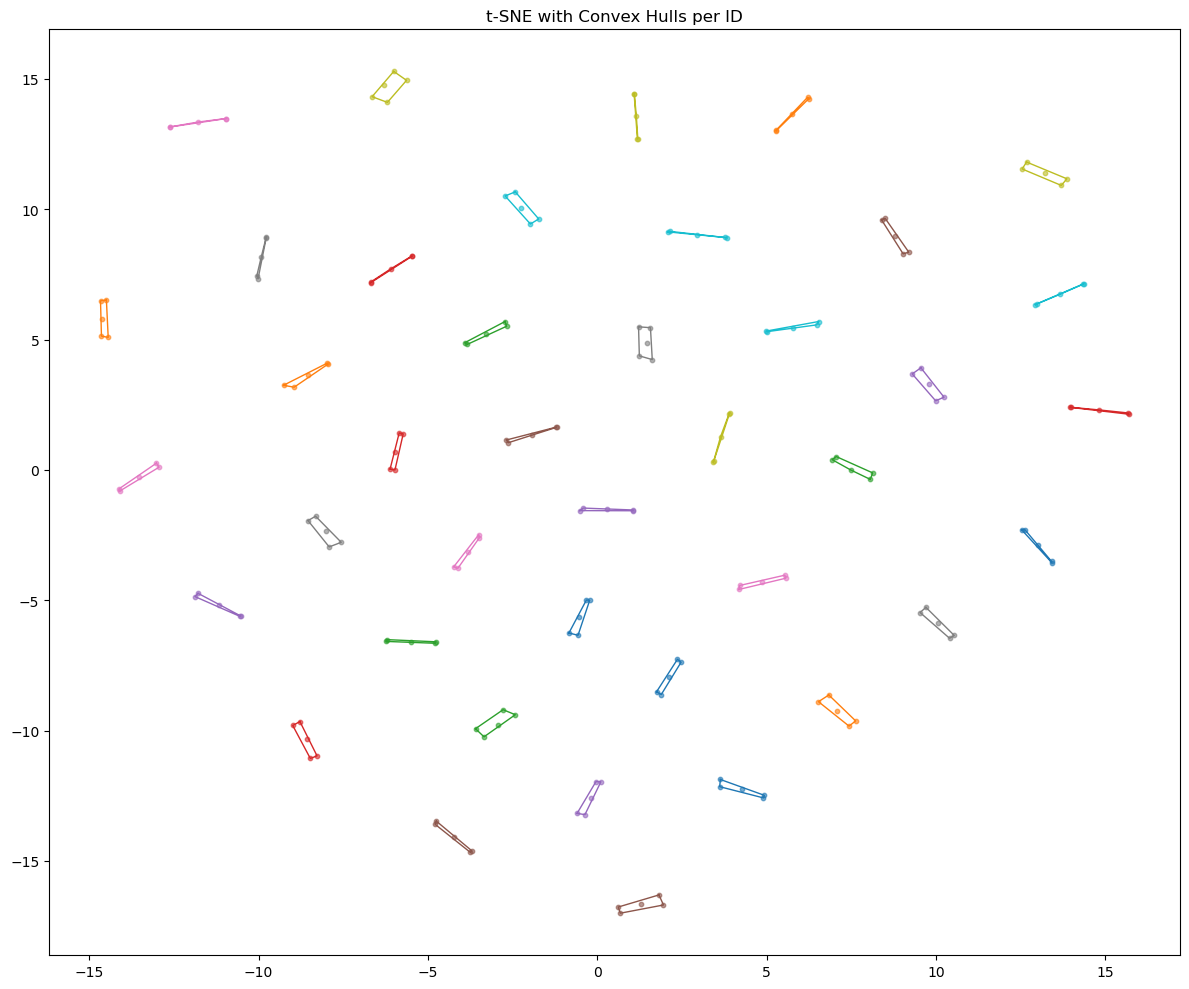

In [297]:
# Now you have run the visualisations on face feature vectors (embeddings) that were not normalised.
# What is the difference between the convex hull visualisation if you normalise the vectors?

# Load the data again, but normalise it!
embeddings, faces, ids = load_numpy_chunks(data_folderpath, normalize=True)

# Compute normaised average 
combined_embeddings, combined_ids = group_and_average_embeddings(embeddings, ids, normalize=True)
# Visualise it!
embeddings_2d=run_tsne_with_hulls(combined_embeddings, combined_ids)

# Would you use normalised vectors?
# Why are they better? Can you see that from the visualisation?



In [298]:
# Let's try UMAP
import umap  # Did you install umap? 
             # pip install umap-learn

def plot_umap_with_hulls(embeddings, ids):
    # Reduce dimensionality using UMAP
    reducer = umap.UMAP(n_components=2, init="pca",random_state=42)
    embeddings_2d = reducer.fit_transform(embeddings)

    plt.figure(figsize=(12, 12))

    unique_ids = np.unique(ids)
    cmap = plt.get_cmap('tab20', len(unique_ids))

    for i, uid in enumerate(unique_ids):
        mask = ids == uid
        points = embeddings_2d[mask]

        # Plot points
        plt.scatter(points[:, 0], points[:, 1], label=f"ID {uid}", color=cmap(i), alpha=0.6)

        # Plot convex hull if there are enough points
        if len(points) >= 3:
            hull = ConvexHull(points)
            for simplex in hull.simplices:
                plt.plot(points[simplex, 0], points[simplex, 1], color=cmap(i), linewidth=1.5)

    plt.title("UMAP Projection with Convex Hulls per Identity")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

/Users/andha390/opt/anaconda3/envs/visualisation/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Users/andha390/opt/anaconda3/envs/visualisation/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



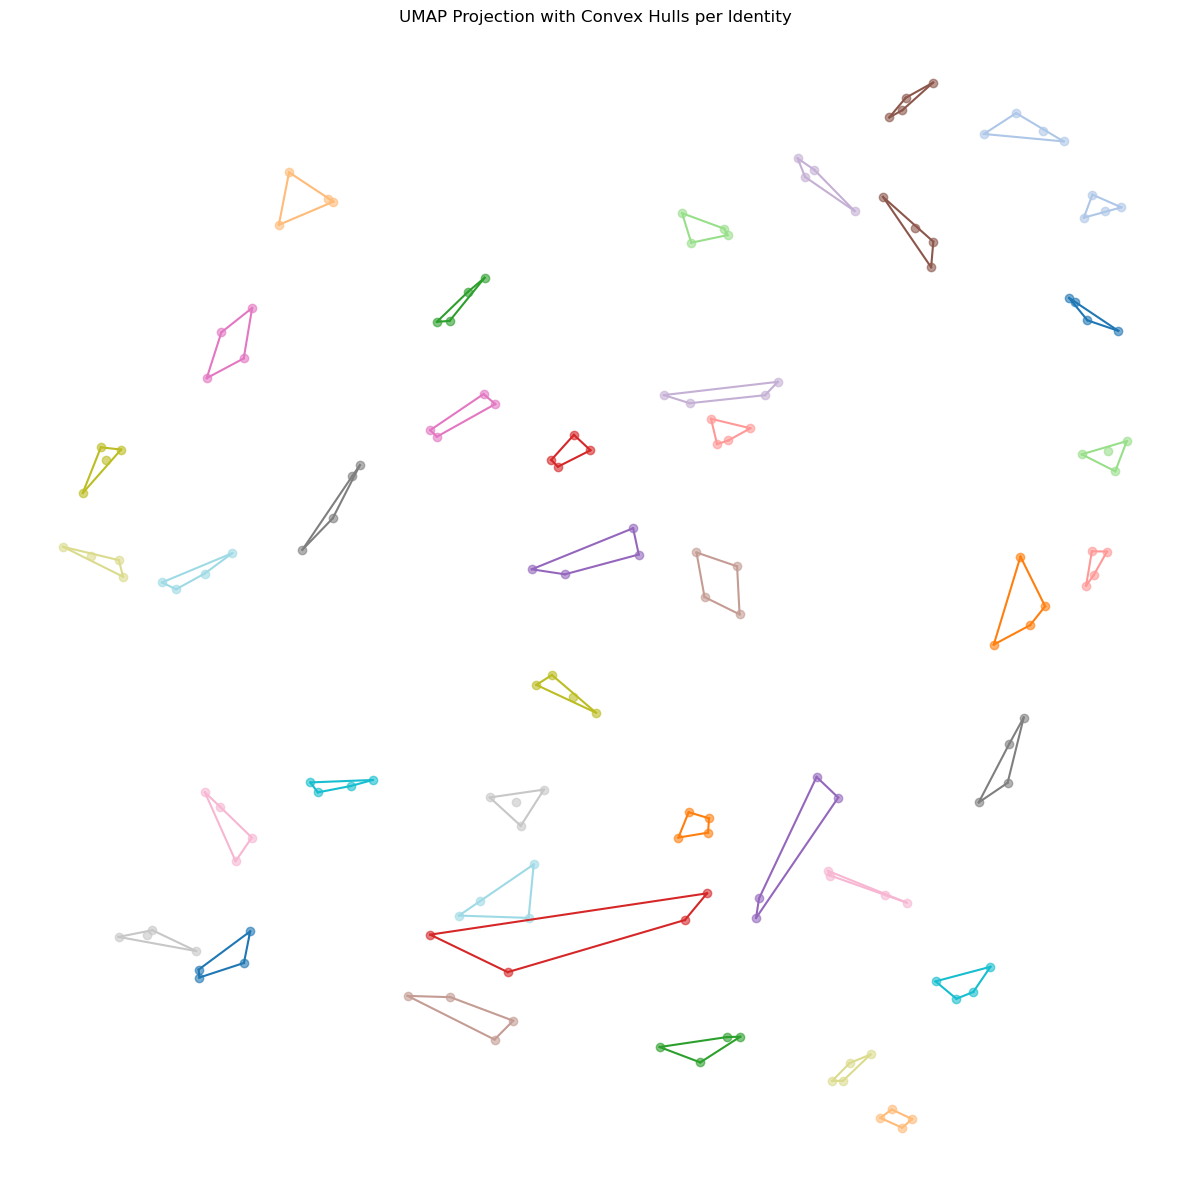

In [299]:
# Run UMAP. What do you think about the result?
# Are the pairs of image and its flipped image still easy to find?

plot_umap_with_hulls(embeddings, ids)

/Users/andha390/opt/anaconda3/envs/visualisation/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Users/andha390/opt/anaconda3/envs/visualisation/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



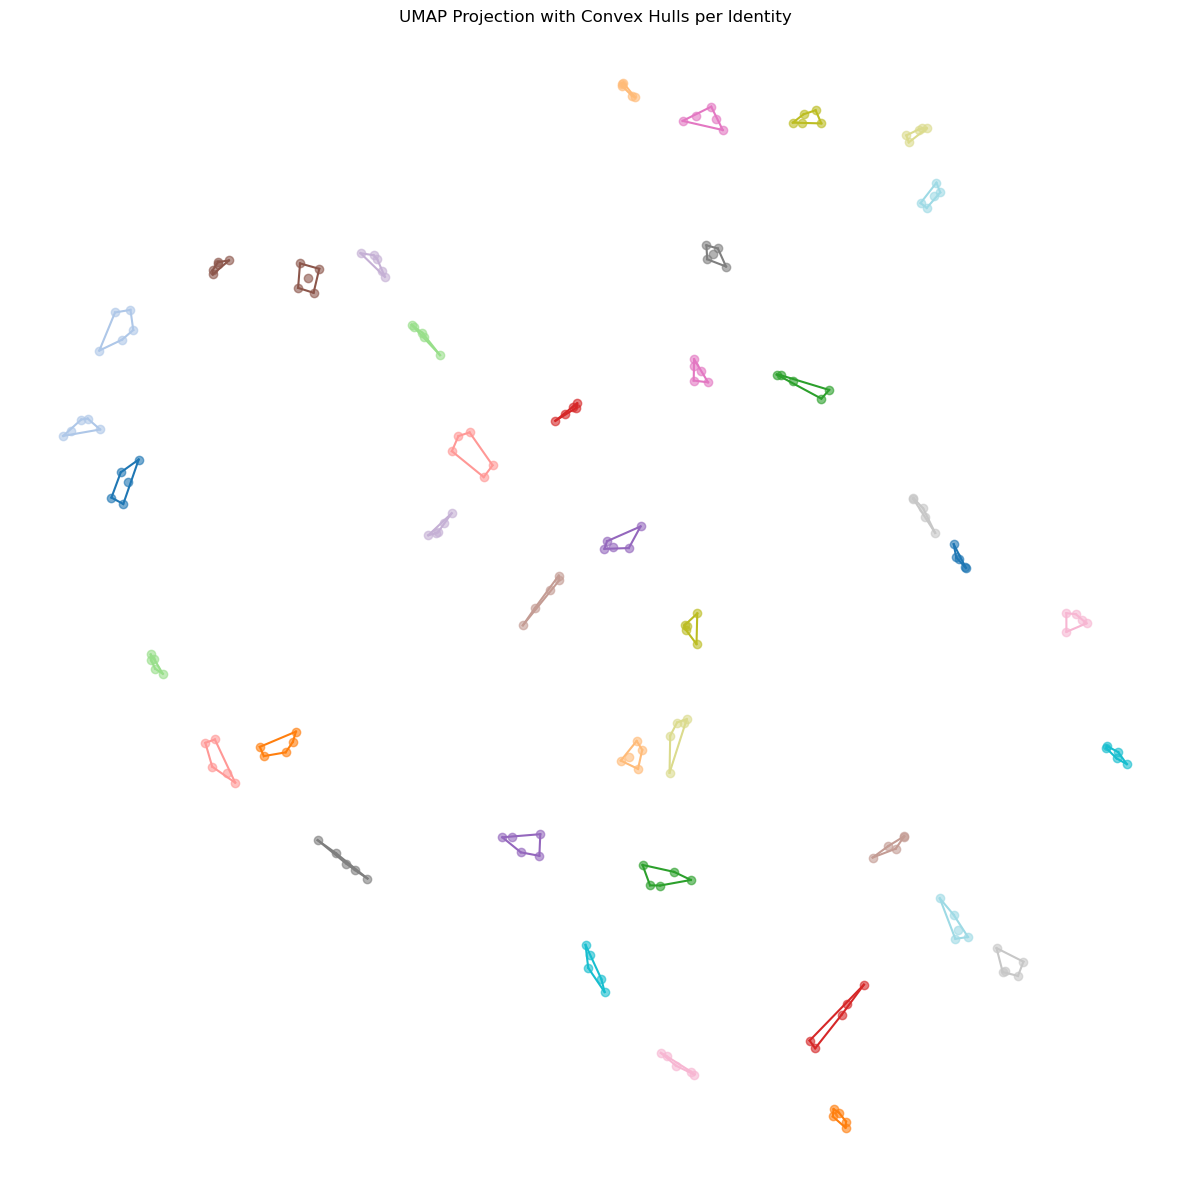

In [300]:
# Let's try adding the average embeddings as well!
# You can also try changing random_state=42 to something else...
# Why do you think there are no "almost overlapping" hulls this time?


plot_umap_with_hulls(combined_embeddings, combined_ids)

In [301]:
# Lessons learned so far:
#
# 1. PCA can perform Dimensionality Reduction, but fails separating clusters in many cases.
# 
# 2. t-SNE is therefore often a better alternative.
# 
# 3. Even if UMAP is said to better preserve the global structure of the data, it is not always true for local structures.
#    See: https://arxiv.org/abs/2002.07481
#    (I have often seen t-SNE perform better and this is what the paper says)
#
# 4. Convex Hulls can help showin how well the embeddings captures the variables in your data. 
#    But of course it only works if you have labels.
#
# 5. Using scattered images instead of coloured data points can help in understanding the data.
#
# 6. The more data points we have in each class the better the clusters forms.
#
# 7. Normalising the embeddings can often improve the results. This is also true when performing classification. 
#    Actually, the dimensionality reduction gives a glimps of how well classification works, i.e.:
#    if clusters overlap, the classification might/will fail.
#


In [302]:
# What to do next? After the lesson (or if you were extremely fast):
# 
# Try the methods presented herein on your own data!
#
# If you have no data, you can explore the data provided in sklearn.datasets as below!

(150, 4)
Running t-SNE...


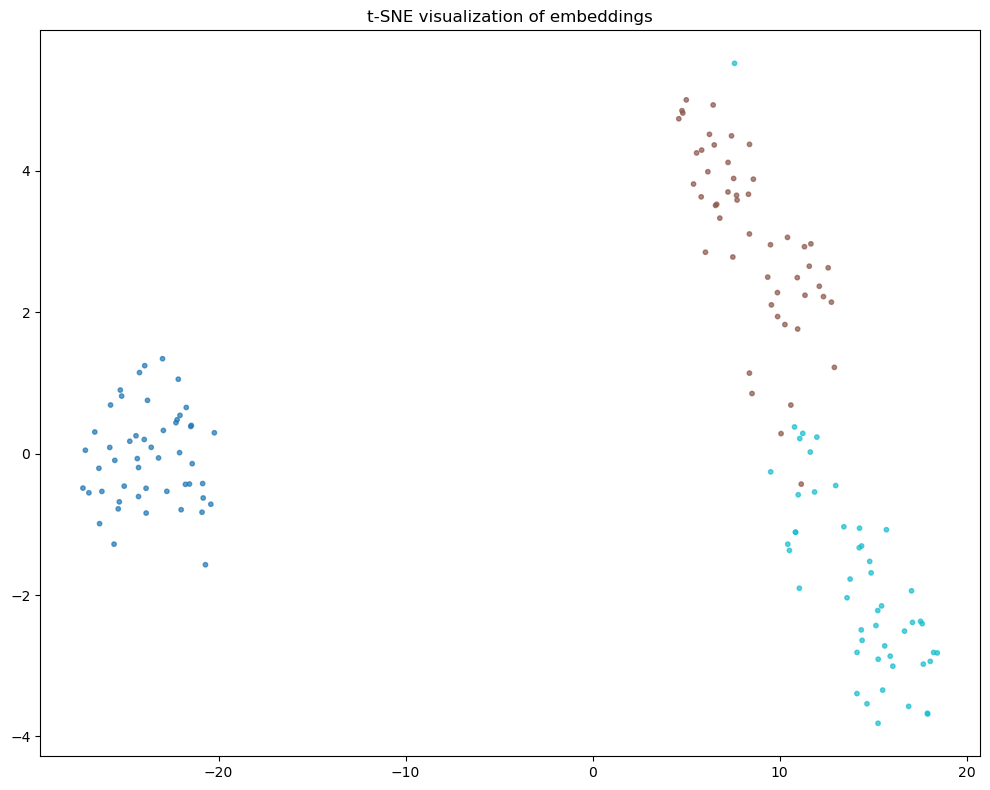

In [303]:
# Load the Iris Dataset (google and you will find a lot of information about it!)
# This dataset works quite well with PCA.
#
from sklearn.datasets import load_iris

iris = load_iris()
embeddings = iris.data
ids=iris.target
print(embeddings.shape)

# Visualise it
embeddings_2d = run_tsne(embeddings, ids)

In [272]:
# A good exercise for you is to make a function that performs PCA and visualise the result and compare with the t-SNE above.
# Also try visualise with Convex Hulls.

(1797, 64)
Running t-SNE...


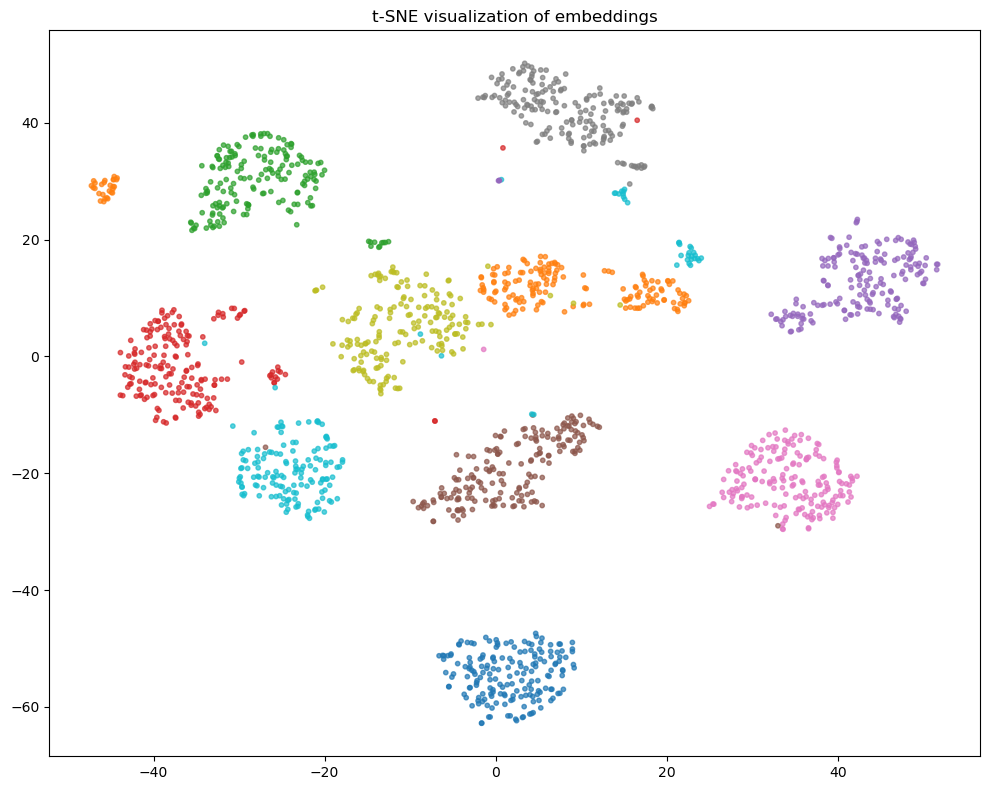

In [304]:
# MNIST is another often used dataset for testing Machine Learning algorithms.
#
from sklearn import datasets

digits = datasets.load_digits()
embeddings=digits.data
ids=digits.target
print(embeddings.shape)

# Visualise it
embeddings_2d = run_tsne(embeddings, ids)

In [278]:
# Obviusly convex hulls on this plot will be a bit messy... but you can try it!
face_images = embeddings